In [46]:
# custom functions for this project
from functions import *
from functions_recs import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

# rec system libraries
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import matutils, models
from gensim.utils import simple_preprocess

# miscellany
import re
from collections import Counter
import time
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# import necessary dataframes
with gzip.open('data/poetry_all_genres_df.pkl', 'rb') as hello:
    df = pickle.load(hello)

In [10]:
# sort genres into umbrella genres
conditions = [
    df.genre == 'victorian', df.genre == 'romantic',
    df.genre == 'new_york_school', df.genre == 'new_york_school_2nd_generation', df.genre == 'confessional',
        df.genre == 'beat', df.genre == 'harlem_renaissance', df.genre == 'black_arts_movement',
    df.genre == 'imagist', df.genre == 'black_mountain', df.genre == 'language_poetry', df.genre == 'objectivist',
    df.genre == 'georgian', df.genre == 'fugitive'
]

# name umbrella genres, prepare 'other' to be dropped
choices = [
    'pre_1900', 'pre_1900',
    'metropolitan', 'metropolitan', 'metropolitan', 'metropolitan', 'metropolitan', 'metropolitan',
    'avant_garde', 'avant_garde', 'avant_garde', 'avant_garde',
    'other', 'other'
]

# convert data, leaving 'modern' untouched
df['umbrella_genre'] = np.select(conditions, choices, df.genre)

In [11]:
df.columns

Index(['poet_url', 'genre', 'poem_url', 'poet', 'title', 'poem_lines',
       'poem_string', 'clean_lines', 'num_lines', 'num_words', 'avg_len_line',
       'sentiment_polarity_score', 'sentiment_polarity',
       'sentiment_subjectivity_score', 'num_end_rhymes', 'end_rhyme_ratio',
       'end_rhyme', 'num_syllables', 'avg_syllables_word', 'lines_titled',
       'string_titled', 'string_cleaned', 'umbrella_genre'],
      dtype='object')

In [12]:
df.sentiment_subjectivity_score.describe()

count    4626.000000
mean        0.476474
std         0.141628
min         0.000000
25%         0.405556
50%         0.484001
75%         0.552169
max         1.000000
Name: sentiment_subjectivity_score, dtype: float64

In [13]:
# drop poems in 'other' umbrella genre
df = df[df.umbrella_genre != 'other']

# take necessary columns
df = df[['title', 'poet', 'genre', 'umbrella_genre', 'num_lines', 'avg_len_line', 'sentiment_polarity',
         'end_rhyme', 'poem_url', 'string_titled']]

# reset the index
df.reset_index(drop=True, inplace=True)

In [14]:
# uncomment to save
with gzip.open('data/poetry_rec_system.pkl', 'wb') as goodbye:
    pickle.dump(df, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# uncomment to load
with gzip.open('data/poetry_rec_system.pkl', 'rb') as hello:
    df = pickle.load(hello)

In [15]:
# create corpus with just titled string of every poem
corpus = df.string_titled

In [16]:
model_corpus = []
for i, line in enumerate(corpus):
    tokens = simple_preprocess(line)
    model_corpus.append(TaggedDocument(tokens, [i]))

In [118]:
model = Doc2Vec(vector_size=100, min_count=5, epochs=50)
model.build_vocab(model_corpus)

In [119]:
model.train(model_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [20]:
df.head()

,title,poet,genre,umbrella_genre,num_lines,avg_len_line,sentiment_polarity,end_rhyme,poem_url,string_titled
0,At the California Institute of Technology,Richard Brautigan,beat,metropolitan,4,6.000000,positive,0,https://www.poetryfoundation.org/poems/48578/at-the-california-institute-of-technology,At the California Institute of Technology I don’t care how God-damn smart these guys are: I’m bored. It’s been raining like hell all day long and ...
1,A Boat,Richard Brautigan,beat,metropolitan,17,2.647059,negative,0,https://www.poetryfoundation.org/poems/48576/a-boat,A Boat O beautiful was the werewolf in his evil forest. We took him to the carnival and he started crying when he saw the Ferris wheel. Electric g...
2,December 30,Richard Brautigan,beat,metropolitan,6,5.500000,positive,1,https://www.poetryfoundation.org/poems/48580/december-30,December 30 At 1:03 in the morning a fart smells like a marriage between an avocado and a fish head. I have to get out of bed to write this down w...
3,The Double-Bed Dream Gallows,Richard Brautigan,beat,metropolitan,17,3.176471,positive,0,https://www.poetryfoundation.org/poems/48579/the-double-bed-dream-gallows,"The Double-Bed Dream Gallows Driving through hot brushy country in the late autumn, I saw a hawk crucified on a barbed-wire fence. I guess as a ki..."
4,Haiku Ambulance,Richard Brautigan,beat,metropolitan,4,3.250000,neutral,0,https://www.poetryfoundation.org/poems/48581/haiku-ambulance,Haiku Ambulance A piece of green pepper fell off the wooden salad bowl: so what?


In [88]:
poem_similarity('Haiku Ambulance', df, model, num_poems=5, to_print=True)

58.3% match
THE MURDER OF TWO MEN BY A YOUNG KID WEARING LEMON-COLORED GLOVES by Kenneth Patchen
GENRE: Beat
URL: https://www.poetryfoundation.org/poems/46346/the-murder-of-two-men-by-a-young-kid-wearing-lemon-colored-gloves
----------------------------------------------------------------------------------------------------
58.1% match
EXPOSITION OF THE CONTENTS OF A CAB by Wallace Stevens
GENRE: Modern
URL: https://www.poetryfoundation.org/poetrymagazine/poems/14571/exposition-of-the-contents-of-a-cab
----------------------------------------------------------------------------------------------------
58.1% match
THE PURITAN ETHOS by Robert Creeley
GENRE: Black Mountain
URL: https://www.poetryfoundation.org/poetrymagazine/poems/30990/the-puritan-ethos
----------------------------------------------------------------------------------------------------
57.5% match
COLOR by Christina Rossetti
GENRE: Victorian
URL: https://www.poetryfoundation.org/poems/43199/color-56d221e6ec8fc
----------

[(77, 0.5830745100975037),
 (2329, 0.5812638998031616),
 (388, 0.5808207392692566),
 (4171, 0.574972927570343),
 (1643, 0.5701456069946289)]

# FIRST MODEL RESULTS

In [41]:
poem_similarity('Haiku Ambulance', df, model, num_poems=5, to_print=True)

61.5% match
THE PURITAN ETHOS by Robert Creeley
GENRE: Black Mountain
URL: https://www.poetryfoundation.org/poetrymagazine/poems/30990/the-puritan-ethos
----------------------------------------------------------------------------------------------------
60.4% match
“A MONSTER OWL” by Lorine Niedecker
GENRE: Objectivist
URL: https://www.poetryfoundation.org/poetrymagazine/poems/56428/a-monster-owl
----------------------------------------------------------------------------------------------------
60.4% match
SIX by E. E. Cummings
GENRE: Modern
URL: https://www.poetryfoundation.org/poetrymagazine/poems/22223/six
----------------------------------------------------------------------------------------------------
58.9% match
TIME THE HANGMAN by William Carlos Williams
GENRE: Imagist
URL: https://www.poetryfoundation.org/poetrymagazine/poems/14351/time-the-hangman
----------------------------------------------------------------------------------------------------
58.2% match
PERSPICUITY by 

[(388, 0.6150802373886108),
 (3201, 0.6043911576271057),
 (1643, 0.604366660118103),
 (1239, 0.588645339012146),
 (2042, 0.5816758871078491)]

In [42]:
from sklearn.manifold import TSNE

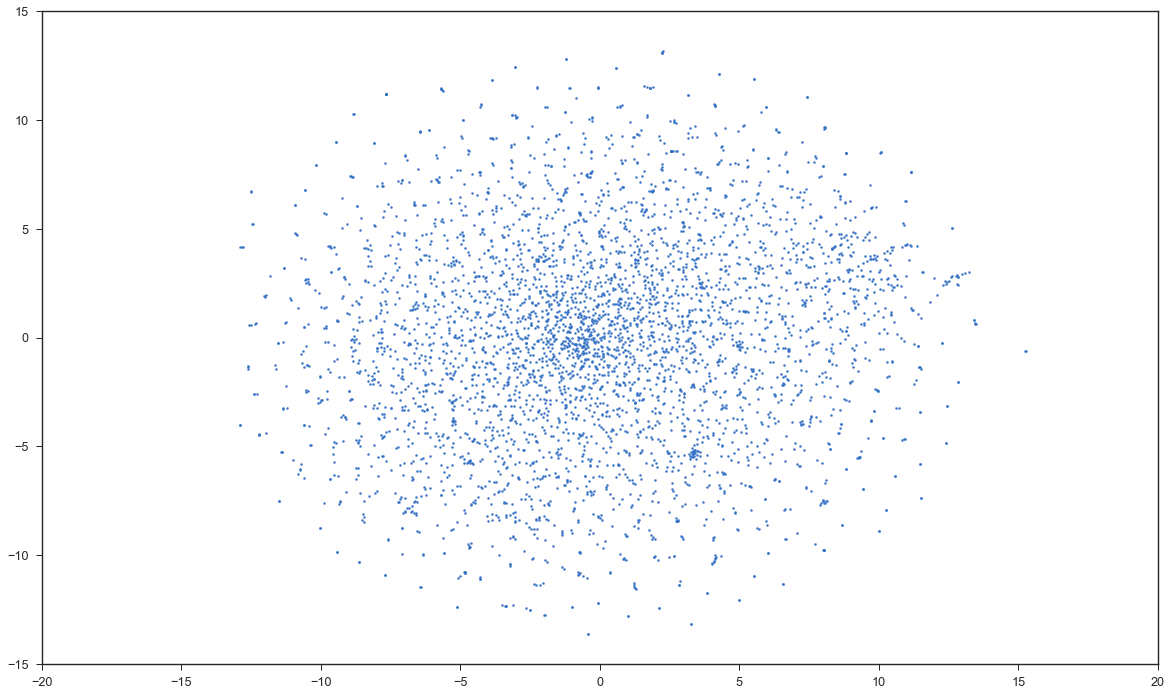

In [160]:
# doc_tags is just a list of every unique document tag/beer_id
doc_tags = [tag[1][0] for tag in model_corpus]
# get the vector for each doc_tag
X = model[doc_tags]
# Fit and transform a t-SNE object with the vector data for dimensionality reduction
tsne = TSNE(n_components=2,
            perplexity=50,
            learning_rate=200,
            n_iter=5000,
            n_jobs=-1, random_state=42)
X_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y'])
# create a scatterplot of the resulting 2-dimensional data
plt.figure(figsize=(20,12))
plt.scatter(df_tsne['x'], df_tsne['y'], s=5)
plt.xlim((-20,20))
plt.ylim((-15,15));

In [156]:
# CURRENT
tsne.kl_divergence_

3.491912841796875

In [148]:
tsne.n_iter_

2599

In [142]:
# FORMER
tsne.kl_divergence_

3.1930837631225586

In [55]:
from functions_recs import make_tsne_subset

In [59]:
umbrella_genres

array(['metropolitan', 'avant_garde', 'modern', 'pre_1900'], dtype=object)

In [61]:
df.shape

(4376, 10)

In [63]:
df_tsne.shape

(4376, 2)

In [66]:
df.umbrella_genre.value_counts()

modern          1279
metropolitan    1092
pre_1900        1041
avant_garde      964
Name: umbrella_genre, dtype: int64

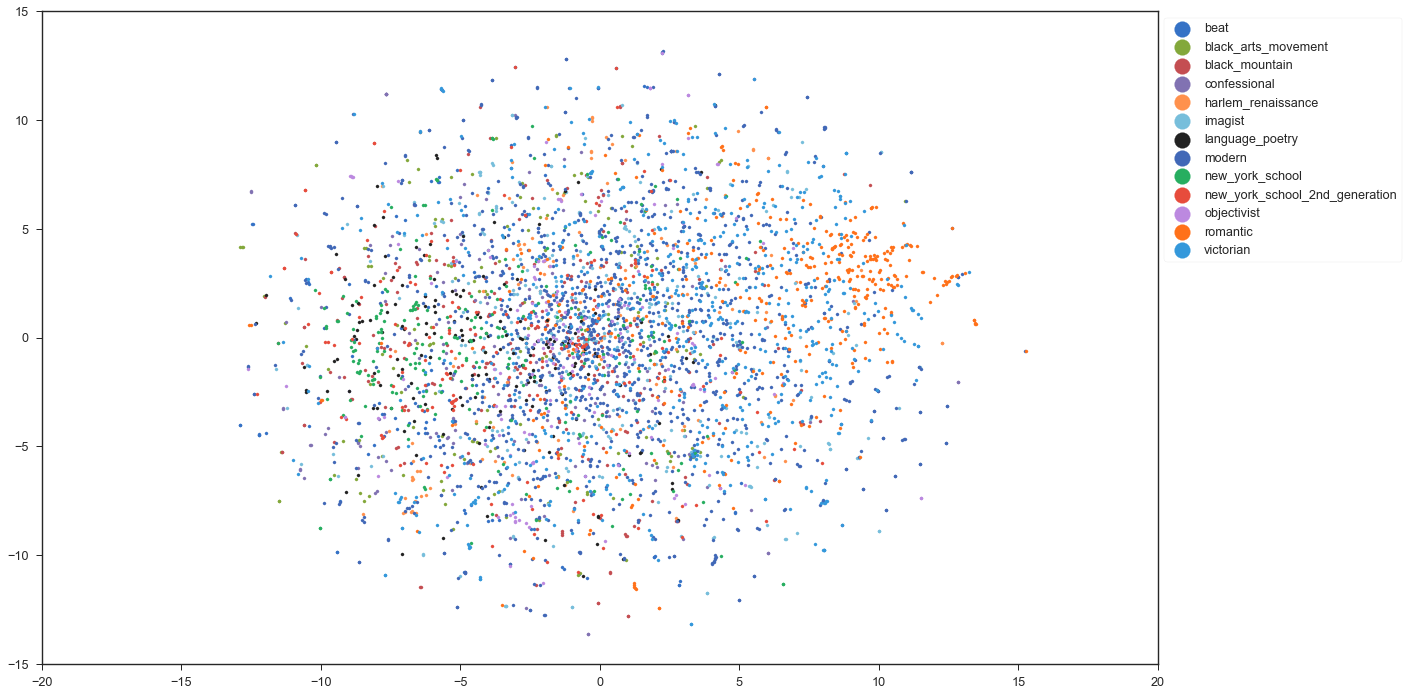

In [163]:
genres = df['genre'].unique()
# iterates through every unique beer style and plots with color
fig = plt.figure(figsize=(20,12))
ax = plt.subplot(111)
for genre in genres:
    genre_subset = make_tsne_subset(df_tsne, df, 'genre', genre)
    plt.scatter(genre_subset['x'], genre_subset['y'], s=10)
ax.legend(genres, bbox_to_anchor=(1,1), markerscale=5)
ax.set_xlim((-20,20))
ax.set_ylim((-15,15));

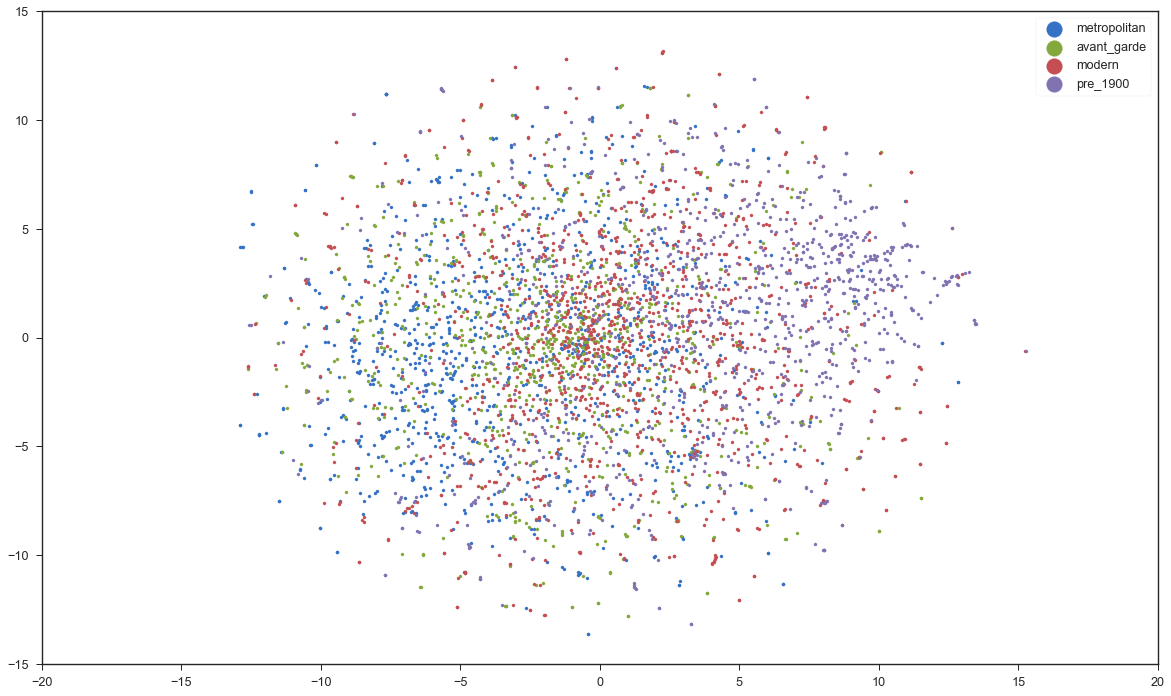

In [164]:
genres = df['umbrella_genre'].unique()
# iterates through every unique beer style and plots with color
fig = plt.figure(figsize=(20,12))
ax = plt.subplot(111)
for genre in genres:
    genre_subset = make_tsne_subset(df_tsne, df, 'umbrella_genre', genre)
    plt.scatter(genre_subset['x'], genre_subset['y'], s=10)
ax.legend(genres, bbox_to_anchor=(1,1), markerscale=5)
ax.set_xlim((-20,20))
ax.set_ylim((-15,15));

In [ ]:
kl_divergence_